In [1]:
#This script is to scan the geometric space of two imaginary Texas Red pairs,
#with respect to the CLAs in LHCII complex

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from math import *
import os

#load vector here
def norm_vector(vector_list):
    vector_normed = []
    for vector in vector_list:
        #print(vector)
        vector_normed.append(vector/np.linalg.norm(vector))
        #print(vector_normed)
    return np.asarray(vector_normed)

def vector_length(vector):
    x,y,z = vector
    return ((x**2+y**2+z**2)**0.5)


def calc_H(dipole1, dipole2, center_vector, dipole_str1, dipole_str2):
    """
    dipole1 and dipole2 are the unit vector in line with its transition dipole moments of Texas-Red and Chlorophyll a.
    center_vector is the vector from one of their center to the other
    r is the distance, which can be caluclated from center_vector
    
    
    ***UNIT***
    dipoles are coming in C*m.
    distance is measured in angstroem
    output H is in meV
    
    """  
    center_vector_normed = center_vector/np.linalg.norm(center_vector)
    
    r = np.linalg.norm(center_vector)   #here r is in angstrom
    r = r*1.0e-10                       #here r is in meter.
    #print("The center vector length is %s" % str(r))
    
    H = -((dipole_str1*dipole_str2)/(4 * constants.pi * 2*permeability_factor * r**3))*\
    (3*np.dot(dipole1,center_vector_normed)*np.dot(dipole2, center_vector_normed) - np.dot(dipole1, dipole2))
    
    #orientation_factor.append(3*np.dot(dipole1,center_vector_normed)*np.dot(dipole2, center_vector_normed))
    
    #print("the distance is here: %s" %r)
    return (H*6.242e+21)    #convert H from joules to meV


def load_raw_vector(filename):
    """
    Given file name under the current directory, load the raw data x, y, z, starting x, starting y, starting z.
    file is loaded as array[framenumber, 7], like this
    array([ 1.    , -2.3211,  3.6332, -2.0481, 82.9937, 14.6032, 56.2966])
        
    
    And return as a dictionary as requested to vector and vector_start:
    [
    [x,y,z]
    [x,y,z]
    ...
    ]
    """
    filedata = np.loadtxt(filename)
    vector = filedata[:,1:4]
    #print(vector.shape)
    vector_start = filedata[:,4:]
    return ({"vector": vector, "vector_start": vector_start})


In [2]:
def get_avg_vector_start(mol):
    """
    take in cpptraj vector output file using load_raw_vector function
    average the starting point and return a (x,y,z)
    
    for example mol could be:
    "cla612_dipole"
    "tex1_dipole"
    
    """
    starting_points = load_raw_vector(mol)["vector_start"]
    
    average_starting_point = np.mean(np.asarray(starting_points), axis=0)
    
    return average_starting_point

def get_avg_vector(mol):

    dipoles = load_raw_vector(mol)["vector"]
    
    average_dipoles = np.mean(np.asarray(dipoles), axis=0)
    
    return average_dipoles

def calc_distance(point1, point2):
    x1,y1,z1 = point1
    x2,y2,z2 = point2
    return (sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2))

def shrink_vector(vector, length):
    """
    Given the length, shrink/enlarge the original vector(x,y,z)
    """
    original_length = np.linalg.norm(vector)
    #print("the original length is %s" %original_length)
    
    vector = vector/(original_length/length)
    return vector
    
def move_vectorxy(vector, length):
    """
    Given the length, shrink/enlarge the original vector(x,y) only, keep the z still.
    """
    original_length = np.linalg.norm(vector)
    x,y,z = vector
    xy_vector = np.array([x,y])
    
    xy_vector_length2be = sqrt(length**2 - z**2)
    xy_vector_shrinked = shrink_vector(xy_vector, xy_vector_length2be)
    
    return (np.array([xy_vector_shrinked[0], xy_vector_shrinked[1], z]))
    

In [3]:
"""
To do the whole scan, we will need :

CLA unit vector (no change with respect to MD data)
CLA dipole (constant)

Tex unit vector  shift from MD data given the other point(CLA? LHCII?) chose CLA612 for the moment
Tex dipole (when vector is decided, use MD angle average to obtain the dipole) (or we should stick to Skauge's ~30 degree)

note the average angle between z-axis is 40.3 degree = 40.3 *(180/pi) rad = 0.7033 rad
we are averaging the cylincal surface, so the unit vector of TEX will be (0,0,1), dipole strength is 10D * cos(40.3 degree)

"""

cla612_vector_start = get_avg_vector_start("cla612_dipole.dat")
tex1_vector_start = get_avg_vector_start("tex1_dipole.dat")
tex4_vector_start = get_avg_vector_start("tex4_dipole.dat")
cla612_dipole = get_avg_vector("cla612_dipole.dat")


CLA_Dipole = 4.5  ###5.524   #in Debye
CHL_Dipole = 3.8  ###4.595  #In Debye
Tex_Dipole = 10   ###20   #In Debye


CLA_Dipole *= 3.3356e-30    #in C*m
CHL_Dipole *= 3.3356e-30    #in C*m
Tex_Dipole *= 3.3356e-30    #in C*m

permeability_factor = 8.8541878e-12  

tex1_dipole_str = Tex_Dipole * cos(0.7033)
tex1_dipole = np.array([0,0,1])

tex4_dipole_str = Tex_Dipole * cos(0.7033)
tex4_dipole = np.array([0,0,1])

tex1_dipole_dic = {
"chl601_dipole.dat":[], 
"chl601_Qx_dipole.dat":[], 
"chl608_dipole.dat":[], 
"chl608_Qx_dipole.dat":[], 
"cla610_dipole.dat":[], 
"cla610_Qx_dipole.dat":[], 
"cla611_dipole.dat":[], 
"cla611_Qx_dipole.dat":[], 
"cla612_dipole.dat":[], 
"cla612_Qx_dipole.dat":[],
}

tex4_dipole_dic = {      #creat a copy of dictionary! note you cant use dict1 = dict2, you will be ending editing both dictionary at the end.
"chl601_dipole.dat":[], 
"chl601_Qx_dipole.dat":[], 
"chl608_dipole.dat":[], 
"chl608_Qx_dipole.dat":[], 
"cla610_dipole.dat":[], 
"cla610_Qx_dipole.dat":[], 
"cla611_dipole.dat":[], 
"cla611_Qx_dipole.dat":[], 
"cla612_dipole.dat":[], 
"cla612_Qx_dipole.dat":[],
}    
#doing scan for tex1 here
for scanpoint in np.arange(27,71,1):
    #print(scanpoint)
    original_center_vector =   tex1_vector_start - cla612_vector_start
    moved_center_vector = move_vectorxy(original_center_vector, scanpoint)
    moved_tex_center = cla612_vector_start + moved_center_vector    #here we obtained the "imaginary texas red" center in the scan
    
    for i in tex1_dipole_dic.keys():
        #here we determine cla/chl dipole, also distinguish Qx/Qy
        print("processing data: %s in scanpoint %s" %(str(i), scanpoint))
        if "cla" in str(i):
            dipole_str_temp = CLA_Dipole
        elif "chl" in str(i):
            dipole_str_temp = CHL_Dipole
    
        if "Qx" in str(i):
            dipole_str_temp *= 0.45    #changed from 0.67 to 0.45
        tex1_dipole_dic[str(i)].append(calc_H(get_avg_vector(str(i)), tex1_dipole, moved_tex_center - get_avg_vector_start(str(i)), dipole_str_temp, tex1_dipole_str))

    
    
    #print(moved_center_vector)
    #print(np.linalg.norm(moved_center_vector))
    


processing data: chl601_dipole.dat in scanpoint 27
processing data: chl601_Qx_dipole.dat in scanpoint 27
processing data: chl608_dipole.dat in scanpoint 27
processing data: chl608_Qx_dipole.dat in scanpoint 27
processing data: cla610_dipole.dat in scanpoint 27
processing data: cla610_Qx_dipole.dat in scanpoint 27
processing data: cla611_dipole.dat in scanpoint 27
processing data: cla611_Qx_dipole.dat in scanpoint 27
processing data: cla612_dipole.dat in scanpoint 27
processing data: cla612_Qx_dipole.dat in scanpoint 27
processing data: chl601_dipole.dat in scanpoint 28
processing data: chl601_Qx_dipole.dat in scanpoint 28
processing data: chl608_dipole.dat in scanpoint 28
processing data: chl608_Qx_dipole.dat in scanpoint 28
processing data: cla610_dipole.dat in scanpoint 28
processing data: cla610_Qx_dipole.dat in scanpoint 28
processing data: cla611_dipole.dat in scanpoint 28
processing data: cla611_Qx_dipole.dat in scanpoint 28
processing data: cla612_dipole.dat in scanpoint 28
proc

processing data: cla612_Qx_dipole.dat in scanpoint 42
processing data: chl601_dipole.dat in scanpoint 43
processing data: chl601_Qx_dipole.dat in scanpoint 43
processing data: chl608_dipole.dat in scanpoint 43
processing data: chl608_Qx_dipole.dat in scanpoint 43
processing data: cla610_dipole.dat in scanpoint 43
processing data: cla610_Qx_dipole.dat in scanpoint 43
processing data: cla611_dipole.dat in scanpoint 43
processing data: cla611_Qx_dipole.dat in scanpoint 43
processing data: cla612_dipole.dat in scanpoint 43
processing data: cla612_Qx_dipole.dat in scanpoint 43
processing data: chl601_dipole.dat in scanpoint 44
processing data: chl601_Qx_dipole.dat in scanpoint 44
processing data: chl608_dipole.dat in scanpoint 44
processing data: chl608_Qx_dipole.dat in scanpoint 44
processing data: cla610_dipole.dat in scanpoint 44
processing data: cla610_Qx_dipole.dat in scanpoint 44
processing data: cla611_dipole.dat in scanpoint 44
processing data: cla611_Qx_dipole.dat in scanpoint 44
p

processing data: cla612_Qx_dipole.dat in scanpoint 58
processing data: chl601_dipole.dat in scanpoint 59
processing data: chl601_Qx_dipole.dat in scanpoint 59
processing data: chl608_dipole.dat in scanpoint 59
processing data: chl608_Qx_dipole.dat in scanpoint 59
processing data: cla610_dipole.dat in scanpoint 59
processing data: cla610_Qx_dipole.dat in scanpoint 59
processing data: cla611_dipole.dat in scanpoint 59
processing data: cla611_Qx_dipole.dat in scanpoint 59
processing data: cla612_dipole.dat in scanpoint 59
processing data: cla612_Qx_dipole.dat in scanpoint 59
processing data: chl601_dipole.dat in scanpoint 60
processing data: chl601_Qx_dipole.dat in scanpoint 60
processing data: chl608_dipole.dat in scanpoint 60
processing data: chl608_Qx_dipole.dat in scanpoint 60
processing data: cla610_dipole.dat in scanpoint 60
processing data: cla610_Qx_dipole.dat in scanpoint 60
processing data: cla611_dipole.dat in scanpoint 60
processing data: cla611_Qx_dipole.dat in scanpoint 60
p

In [4]:
print(len(tex1_dipole_dic["cla612_dipole.dat"]))

44


Text(0.5, 0, 'Distance (A)')

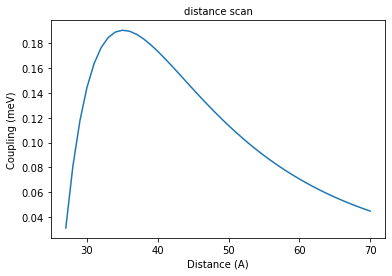

In [5]:
xaxis = np.arange(27,71,1)
plt.plot(xaxis, tex1_dipole_dic["cla611_dipole.dat"])
plt.title('distance scan', fontsize=10)
#plt.ylim(-1, 1)
plt.ylabel("Coupling (meV)")
plt.xlabel("Distance (A)")

In [6]:
print(len(tex1_dipole_dic["cla612_dipole.dat"]))

44


In [7]:
#doing scan for tex4 here
for scanpoint in np.arange(27,71,1):
    #print(scanpoint)
    original_center_vector =   tex4_vector_start - cla612_vector_start
    moved_center_vector = move_vectorxy(original_center_vector, scanpoint)
    moved_tex_center = cla612_vector_start + moved_center_vector    #here we obtained the "imaginary texas red" center in the scan
    
    for i in tex4_dipole_dic.keys():
        #here we determine cla/chl dipole, also distinguish Qx/Qy
        #print("processing data: %s in scanpoint %s" %(str(i), scanpoint))
        if "cla" in str(i):
            dipole_str_temp = CLA_Dipole
        elif "chl" in str(i):
            dipole_str_temp = CHL_Dipole
    
        if "Qx" in str(i):
            dipole_str_temp *= 0.45    #changed from 0.67 to 0.45
        tex4_dipole_dic[str(i)].append(calc_H(get_avg_vector(str(i)), tex4_dipole, moved_tex_center - get_avg_vector_start(str(i)), dipole_str_temp, tex4_dipole_str))


In [8]:
print()

Text(0.5, 0, 'Distance (A)')

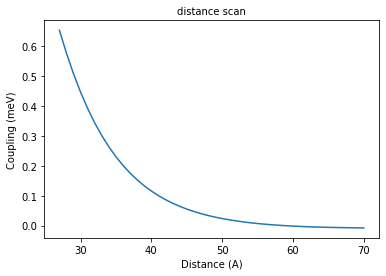

In [9]:
xaxis = np.arange(27,71,1)
plt.plot(xaxis, tex4_dipole_dic["cla610_dipole.dat"])
plt.title('distance scan', fontsize=10)
#plt.ylim(-1, 1)
plt.ylabel("Coupling (meV)")
plt.xlabel("Distance (A)")

In [10]:
import csv

with open('tex1_coupling_scan.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    #w.writeheader()
    for row in tex1_dipole_dic.items():
        w.writerow(row)
    
with open('tex4_coupling_scan.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    #w.writeheader()
    for row in tex4_dipole_dic.items():
        w.writerow(row)
        

In [11]:
"""
from scipy import constants
#Define spectral overlap here:
overlap_claqy = 1.2944
overlap_claqx = 1.7604
overlap_chlqy = 0.27
overlap_chlqx = 3.94503267331681

def coupling2rate(coupling_dictionary):
    for i in coupling_dictionary.keys():
        #as usual, determine the spectral overlap here.
        if "cla" in str(i):
            if "Qx" in str(i):
                overlap = overlap_claqx
            else:
                overlap = overlap_claqy
        elif "chl" in str(i):
            if "Qx" in str(i):
                overlap = overlap_chlqx
            else:
                overlap = overlap_chlqy
        #start to play each coupling number in the list:
        for j in range(0,len(coupling_dictionary[str(i)])):
            print(str(i))
            coupling_dictionary[str(i)][j] *=  10^-3
            coupling_dictionary[str(i)][j] = coupling_dictionary[str(i)][j]**2
            coupling_dictionary[str(i)][j] *= 2*constants.pi/constants.hbar
            coupling_dictionary[str(i)][j] *= overlap
            coupling_dictionary[str(i)][j] = (1/coupling_dictionary[str(i)][j])*10^12
    return #note the output rate dictionary is in pico seconds
"""

In [13]:
#coupling2rate(tex1_dipole_dic)

chl601_dipole.dat


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
#tex1_vector_start - cla612_vector_start

In [ ]:
#calc_distance(tex4_vector_start - get_avg_vector_start("cla612_dipole.dat"), [0,0,0])